In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
plt.style.use('ggplot')

## Load dataset and pickles

In [2]:
with open('data/nyc_network_graph.pkl', 'r') as f:
    G = pickle.load(f)

In [29]:
for node in [42900764, 4665856504]:
    print G.node[node].values()

[40.705293, -73.764134]
[40.666718170064215, -73.764255987001391]


In [28]:
no_path_nodes = [1203806738, 1203806324, 1698103479,
                 3369517460, 1209744536, 2303669060, 30807348,
                593909360, 1774037010, 1774036509, 1203806236]
for node in no_path_nodes:
    try:
        G.remove_node(node)
    except:
        continue

In [5]:
data_path = '../analytics/data/taxi_trips/mmdata_2016-05.csv'
dataset = pd.read_csv(data_path, nrows=500000)
dataset = dataset[['trip_time', 'phash', 'plat', 'plon', 'dhash', 'dlat', 'dlon', 'second']]
# dataset['trip_distance'] *= 1000
dataset.head()

,trip_time,phash,plat,plon,dhash,dlat,dlon,second
0,17.516667,dr5rumt,40.768249,-73.985475,dr5rsqw,40.729667,-73.983788,0
1,7.016667,dr5ru0z,40.742039,-73.993433,dr5ru92,40.744732,-73.980941,0
2,19.783333,dr5rkq2,40.684367,-73.992064,dr5rsp1,40.732507,-74.001829,0
3,7.516667,dr5ru32,40.745078,-73.992071,dr5ruth,40.765470,-73.975744,0
4,6.650000,dr5rgbx,40.740652,-74.004656,dr5ru0h,40.737793,-73.997871,0


In [6]:
with open('model/pickle/demand_predictor.pkl', 'r') as f:
    model = pickle.load(f)

In [7]:
from simulator import FleetSimulator
from agent import Agent

In [8]:
def run(simulator, agent, T, reposition_cycle=15, verbose=True):
    vehicles, requests, reward = simulator.forward()    
    result = np.zeros((T, 7))
    predicted_demand = 0
    nactions = 0
    for t in range(T):
        if t % 60 == 0 and verbose:
            print "hour=%d" % (t/60.0)
        
        assignments = agent.match(vehicles, requests)
        vehicles, sumwt, reject = simulator.assign(assignments)
        available_resouces = sum(vehicles.available)
        if t > 0 and t % reposition_cycle == 0:
            actions, state = agent.reposition(vehicles)
            predicted_demand = state.W.sum()
            nactions = len(actions)
            simulator.reposition(actions)
            
            if verbose:
                print "t=%d, total_flow=%d" % (t, nactions)

        vehicles, requests, cost = simulator.forward()
        nassigns = len(assignments)
        result[t, :] = (nassigns, sumwt, reject, cost, available_resouces,
                     predicted_demand, nactions)

    result = pd.DataFrame(result, columns=['nassigns', 'sumwt', 'nrejects', 'cost', 'nvehicles', 'prediction', 'nactions'])    
    print "Total rejects: %d" % result.nrejects.sum()
    print "Total assignments: %d" % result.nassigns.sum()
    print "Total cost: %d" % result.cost.sum()
    print "Mean wait time: %.2f" % (result.sumwt.sum()/result.nassigns.sum())

    return result

In [9]:
def plot_result(result, reposition_cycle=15):
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.ylabel('count')
    plt.plot(result.index, result.nassigns+result.nrejects, label='demand')
    plt.plot(result.index, result.nrejects, label='reject')
    plt.plot(result.index, result.nactions, label='reposition')
    plt.plot(result.index, result.prediction/reposition_cycle, label='prediction')
    plt.plot(result.index, result.nvehicles/10, label='vehicle/10')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('wait time')
    plt.plot(result.index, result.sumwt/result.nassigns)
    return plt

## Setup simulator and agent

In [42]:
simulator = FleetSimulator(G, dataset)
simulator.init_vehicles(8000)

In [39]:
zonedf = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(zonedf, model, policy=None, dayofweek=6)

In [40]:
result = run(simulator, agent, T=60*24, reposition_cycle=1e10)

hour=0
hour=1
hour=2
hour=3
hour=4
hour=5
hour=6
hour=7
hour=8
hour=9
hour=10
hour=11
hour=12
hour=13
hour=14
hour=15
hour=16
hour=17
hour=18
hour=19
hour=20
hour=21
hour=22
hour=23
Total rejects: 84919
Total assignments: 331976
Total cost: 0
Mean wait time: 4.49


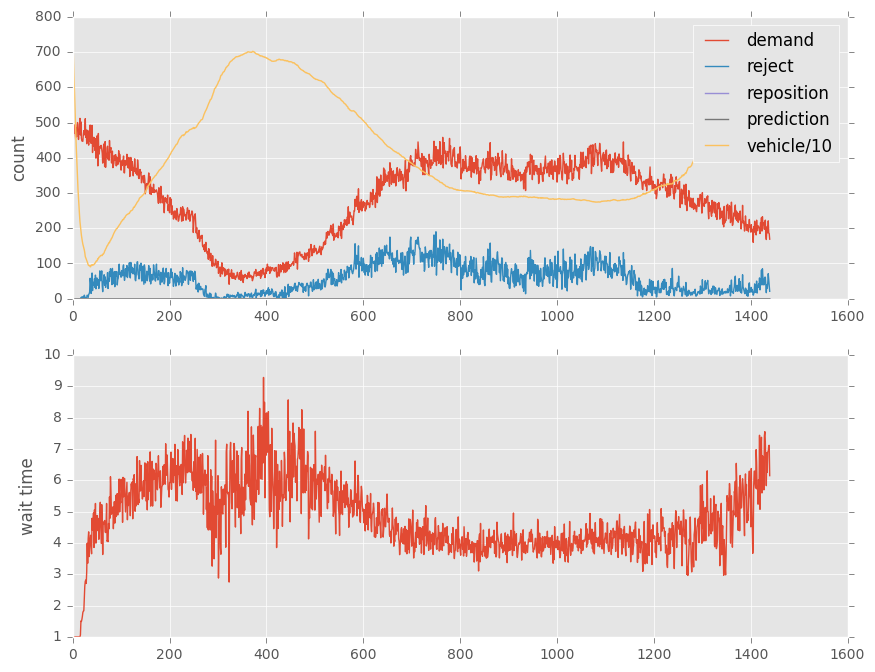

In [45]:
plot_result(result);

In [41]:
from mapper.geohelper import plot_overmap
import geopandas as gpd

nyc = gpd.read_file("../analytics/data/taxi_zones/taxi_zones.shp").to_crs('+proj=latlon')

In [51]:
vehicles, requests, reward = simulator.forward()    
point_y = vehicles[vehicles.available==1].lat.values
point_x = vehicles[vehicles.available==1].lon.values
radius=0.001
plot_overmap(point_x, point_y, radius, nyc)

## Linear Programming Policy

In [45]:
OD_triptime = pd.read_csv('data/OD_distance.csv', index_col='taxi_zone')
OD_triptime = OD_triptime.drop(['lat', 'lon'], axis=1)
taxi_zone = map(int, OD_triptime.index)
OD_triptime.index = taxi_zone
OD_triptime.columns = taxi_zone
speed = 30
OD_triptime /=1000 * speed / 60

In [46]:
from model.lp import LPPolicy

lp = LPPolicy(OD_triptime)

In [47]:
zonedf = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(zonedf, model, policy=lp, dayofweek=6)

In [48]:
simulator = FleetSimulator(G, dataset)
simulator.init_vehicles(8000)

In [49]:
result = run(simulator, agent, T=60*24, reposition_cycle=15)

hour=0
t=15, total_flow=20
t=30, total_flow=164
t=45, total_flow=140
hour=1
t=60, total_flow=140
t=75, total_flow=115
t=90, total_flow=126
t=105, total_flow=135
hour=2
t=120, total_flow=104
t=135, total_flow=100
t=150, total_flow=89
t=165, total_flow=129
hour=3
t=180, total_flow=128
t=195, total_flow=138
t=210, total_flow=105
t=225, total_flow=116
hour=4
t=240, total_flow=81
t=255, total_flow=75
t=270, total_flow=57
t=285, total_flow=112
hour=5
t=300, total_flow=120
t=315, total_flow=153
t=330, total_flow=369
t=345, total_flow=170
hour=6
Map Match Error (40.6860034802, -73.952447160299997)
t=360, total_flow=245
t=375, total_flow=196
t=390, total_flow=343
Map Match Error (40.6860034802, -73.952447160299997)
Map Match Error [40.685774747631001, -73.952380152042352]
t=405, total_flow=235
hour=7
t=420, total_flow=249
t=435, total_flow=150
t=450, total_flow=319
t=465, total_flow=281
hour=8
t=480, total_flow=228
t=495, total_flow=214
t=510, total_flow=242
No Path Error: 42427185 -> 177403701

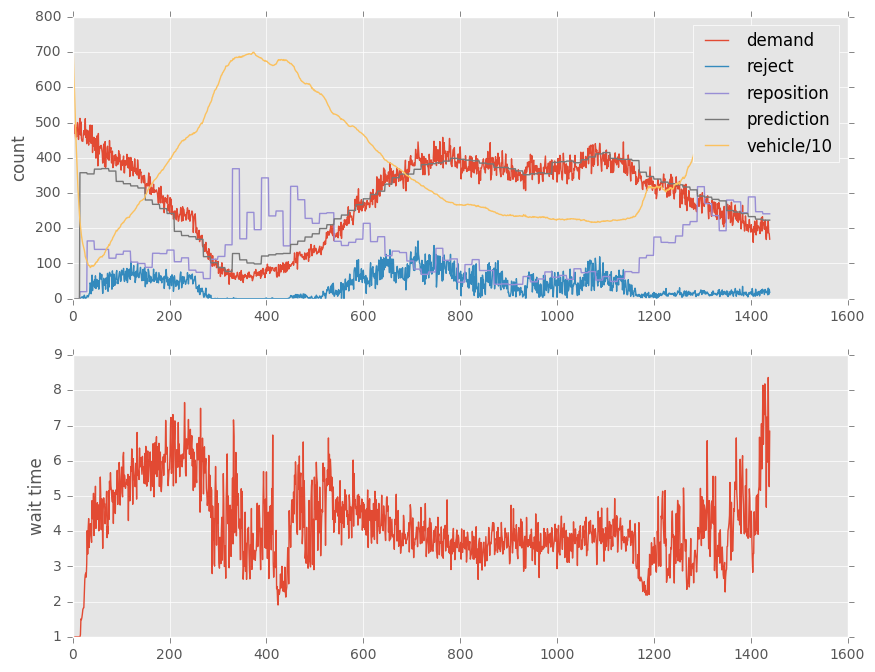

In [50]:
plot_result(result);

In [ ]:
OD_triptime = pd.read_csv('data/OD_distance.csv', index_col='taxi_zone')
OD_triptime = OD_triptime.drop(['lat', 'lon'], axis=1)
taxi_zone = map(int, OD_triptime.index)
OD_triptime.index = taxi_zone
OD_triptime.columns = taxi_zone
speed = 30
OD_triptime /=1000 * speed / 60
lp = LPPolicy(OD_triptime)

In [17]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=15)

hour=0
t=15, total_flow=20
t=30, total_flow=201
t=45, total_flow=236
hour=1
t=60, total_flow=336
t=75, total_flow=317
t=90, total_flow=434
t=105, total_flow=358
hour=2
t=120, total_flow=320
t=135, total_flow=373
t=150, total_flow=364
t=165, total_flow=416
hour=3
t=180, total_flow=371
t=195, total_flow=357
t=210, total_flow=337
t=225, total_flow=364
hour=4
t=240, total_flow=281
t=255, total_flow=250
t=270, total_flow=287
t=285, total_flow=241
hour=5
t=300, total_flow=226
t=315, total_flow=246
t=330, total_flow=864
t=345, total_flow=170
hour=6
t=360, total_flow=264
Map Match Error (40.6974088288, -73.951158526300006)
t=375, total_flow=323
Map Match Error (40.6860034802, -73.952447160299997)
No Path Error: 593909360 -> 42427427
No Path Error: 593909360 -> 42427427
No Path Error: 593909360 -> 42439826
No Path Error: 593909360 -> 42439826
No Path Error: 593909360 -> 42428287
No Path Error: 593909360 -> 42428287
No Path Error: 593909360 -> 42435660
No Path Error: 3104245066 -> 42435654
No Pa

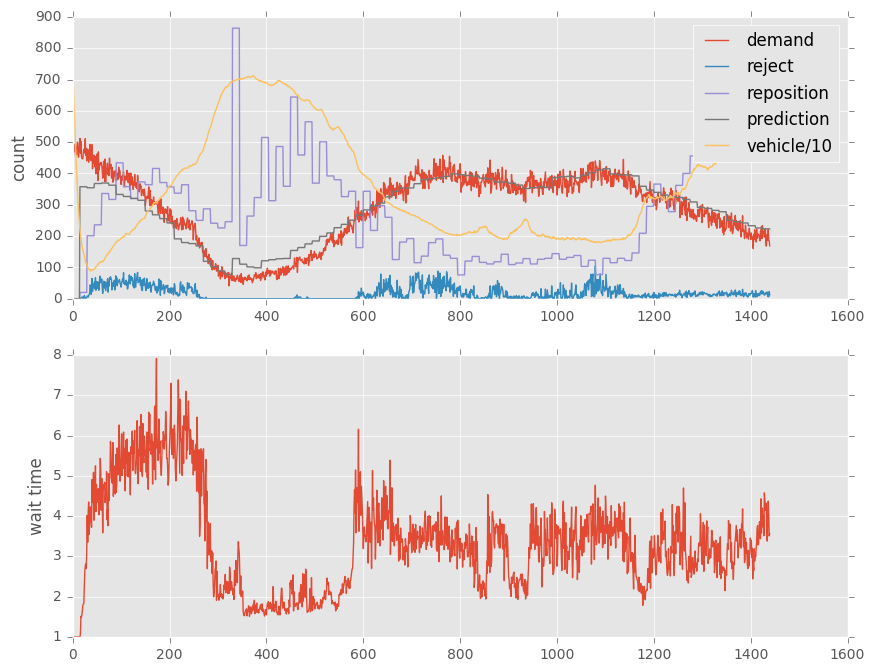

In [18]:
plot_result(result);

## nVehicles = 10000

In [10]:
simulator = FleetSimulator(G, dataset)
simulator.init_vehicles(10000)

In [11]:
zonedf = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(zonedf, model, policy=None, dayofweek=6)

In [12]:
result = run(simulator, agent, T=60*24, reposition_cycle=1e10, verbose=False)

/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1160: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  result = getitem(key)
/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


Total rejects: 58559
Total assignments: 358336
Total cost: 0
Mean wait time: 4.19


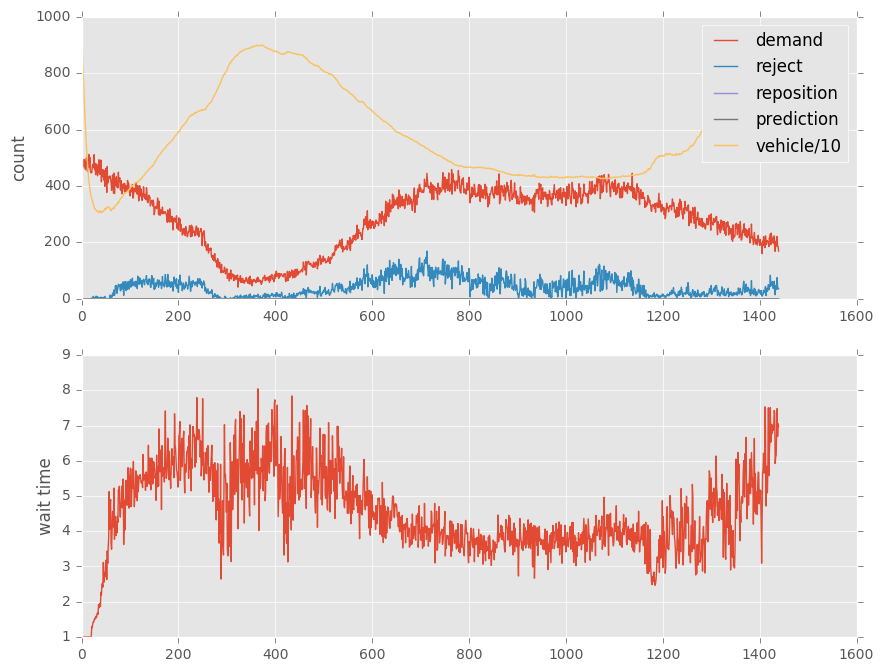

In [13]:
plot_result(result);

In [14]:
OD_triptime = pd.read_csv('data/OD_distance.csv', index_col='taxi_zone')
OD_triptime = OD_triptime.drop(['lat', 'lon'], axis=1)
taxi_zone = map(int, OD_triptime.index)
OD_triptime.index = taxi_zone
OD_triptime.columns = taxi_zone
speed = 30
OD_triptime /=1000 * speed / 60

In [15]:
from model.lp import LPPolicy

lp = LPPolicy(OD_triptime)

In [30]:
zonedf = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(zonedf, model, policy=lp, dayofweek=6)

In [31]:
simulator = FleetSimulator(G, dataset)
simulator.init_vehicles(10000)

In [32]:
result = run(simulator, agent, T=60*24, reposition_cycle=15, verbose=False)

Map Match Error (40.6860034802, -73.952447160299997)
Map Match Error [40.683596520050294, -73.952027901886609]
Map Match Error [40.68547976221452, -73.952461848796659]
Map Match Error (40.6860034802, -73.952447160299997)
No Path Error: 2307002073 -> 42906594
No Path Error: 42900764 -> 4665856504
No Path Error: 42865719 -> 4665856504
Map Match Error (40.6860034802, -73.952447160299997)
Total rejects: 27165
Total assignments: 389730
Total cost: 185696
Mean wait time: 3.53


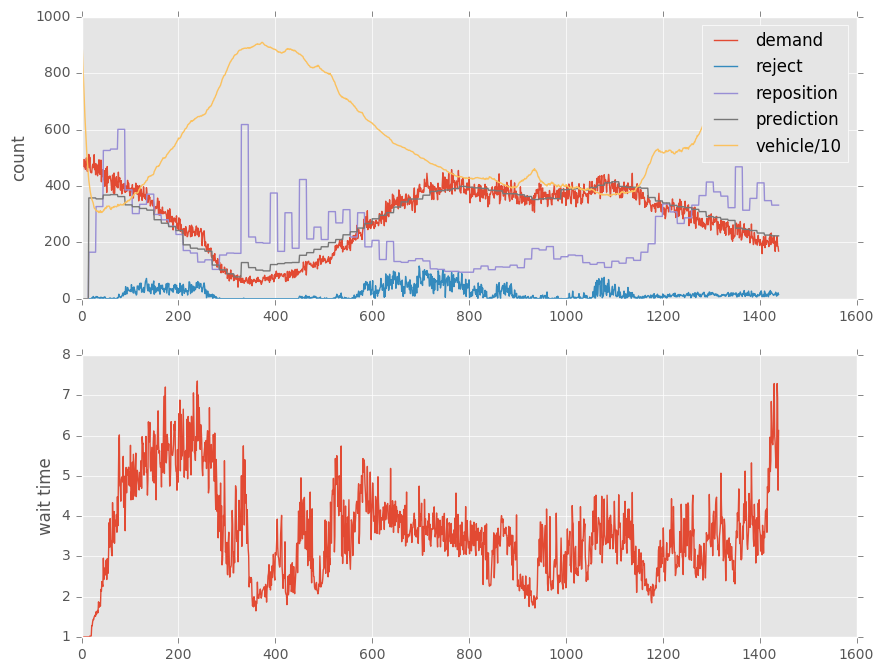

In [33]:
plot_result(result);